In [111]:
NODATA_VALUE = -9999
LCF_HEIGHTS = [0, 0.5, 1, 2, 3]

In [2]:
#imports
import pdal
import numpy as np
import json

from shapely.geometry import Point
from shapely.geometry import MultiPolygon
from shapely.geometry import box
#from shapely.strtree import STRtree

import geopandas as gpd
import pandas as pd
import osmnx as ox

import os

import sys

sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../callingelvis'))

# not using this, using geopandas instead
from rtree import index

# this is needed to create a raster from the output array
from osgeo import gdal
import osgeo.osr as osr

In [3]:
from callingelvis import anybodyhome

import forestmetrics.forestmetrics as metrics
import forestmetrics.utils as forestutils

#import forestpipeline

In [91]:
def comp_veg_layers(points, heights):
    """
    Compute veg layers needed for LCF as per the TERN product manual:
    
    LCF = VCF * (((veg returns below H2) - (veg returns below H1)) / (veg returns below H2))
    
    Inputs:
    - a set of points to compute vegetation counts over
    - an array of heights
    
    Outputs:
    - a dictionary of counts for vegetation points below each height
    
    Conditions:
    
    The LCF *must* be computed over the same set of points as the VCF used as input.
    
    """
    veg_below = {}
    #find veg returns - ASPRS classes 3,4,5
    veg_returns = np.where(np.logical_or(points["Classification"].values == 3,
                             points["Classification"].values == 4,
                             points["Classification"].values == 5))
    # set total of veg returns
    veg_below["all"] = np.size(veg_returns)
    
    # how many veg returns have height below the first threshold?
    for height in heights:
        try:
            # create an ND array (multiband raster) with a band for each height...
            veg_below_height = np.size(np.where(points["HeightAboveGround"].values[veg_returns] < height))
            #print("this LCF: {} height: {}".format(this_lcf, height))
        except ValueError:
            #print('no vegetation returns were present, CTH set to {}'.format(NODATA_VALUE))
            veg_below_height = np.nan

        veg_below[str(height)] = veg_below_height
        
    return(veg_below)


In [21]:
lasfile = "../../callingelvis-sampledata/Berridale201802-LID2-C3-AHD_6585974_55_0002_0002.las"

In [22]:
metadata = forestutils.readlasmetadata(lasfile)

In [23]:
points = forestutils.readlasfile(lasfile)

In [24]:
gdf = forestutils.pdal2df(points)

In [25]:
points = None
lcf= None

In [26]:
this = np.nan
this

nan

In [27]:
sindex = forestutils.spatialindex(gdf)

In [28]:
resolution = 25

In [29]:
cell_polygons = forestutils.gen_raster_cells(metadata, resolution)

In [30]:
 # get tile width and height
tile_width = metadata["metadata"]["readers.las"]["maxx"] - metadata["metadata"]["readers.las"]["minx"]
tile_height = metadata["metadata"]["readers.las"]["maxy"] - metadata["metadata"]["readers.las"]["miny"]

raster_xsize = int(np.ceil(tile_width) / resolution)
raster_ysize = int(np.ceil(tile_height) / resolution)

In [31]:
pixel = cell_polygons[0]

In [42]:
points = forestutils.get_cell_points(pixel, gdf, sindex)

In [61]:
heights = [0, 0.05, 0.5, 1, 2, 3]

In [92]:
veg_below = comp_veg_layers(points, heights)

In [93]:
veg_below

{'all': 2, '0': 0, '0.05': 0, '0.5': 0, '1': 0, '2': 2, '3': 2}

In [126]:

veg_below_dict = {}

veg_below_dict["all"] = np.zeros((raster_xsize, raster_ysize))
for height in heights:
    veg_below_dict[str(height)] = np.zeros((raster_xsize, raster_ysize))
    
vcf_raster = np.zeros((raster_xsize, raster_ysize))


print(np.shape(lcf_raster))


for pixel in cell_polygons:
    
    #compute output array index for this cell:
    poly_x, poly_y = pixel.centroid.xy

    poly_base_x = poly_x[0] - metadata["metadata"]["readers.las"]["minx"]
    poly_base_y = poly_y[0] - metadata["metadata"]["readers.las"]["miny"]

    array_x = int(np.floor((poly_base_x / (resolution)) ))
    array_y = int(np.floor((poly_base_y / (resolution)) ))
    
    points = forestutils.get_cell_points(pixel, gdf, sindex)
    vcf = metrics.comp_vcf(points)
    # comp_veg_layers returns a dictionary of values
    veg_below = comp_veg_layers(points, heights)
    
    #first band is total veg points
    veg_below_dict["all"][array_x, array_y] = veg_below["all"]
                                                      
    for band, height in enumerate(heights):
        #print(band)
        #print(veg_below)
        #print(height)
        veg_below_dict[str(height)][array_x, array_y] = veg_below[str(height)]
        
    vcf_raster[array_x, array_y] = vcf

    

(80, 80, 6)


In [118]:
# now we have a dictionary of rasters using the values we need to compute VCF!

#HI=(Nlt100-Nlt005)./Nlt100;
#USI=(Nlt300-Nlt100)./Nlt300;
#OSI=(Nvtot-Nlt300)./Nvtot;
#LCF_H=VCF.*HI;
#LCF_OS=VCF.*OSI;
#LCF_US=VCF.*USI;

lcf_h = vcf * np.divide((veg_below_raster["0.05"] - veg_below_raster["1"]),
                        veg_below_raster["1"])
lcf_os = vcf * np.divide((veg_below_raster["3"] - veg_below_raster["1"]),
                        veg_below_raster["3"])
lcf_us = vcf * np.divide((veg_below_raster["all"] - veg_below_raster["3"]),
                        veg_below_raster["all"])


/Users/adam/anaconda3/envs/callingelvis/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/adam/anaconda3/envs/callingelvis/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/adam/anaconda3/envs/callingelvis/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [119]:
from matplotlib import pyplot as plt

%matplotlib inline

Text(0.5, 1.0, 'Layer cover')

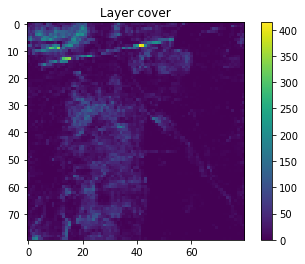

In [121]:
plt.imshow(np.rot90(veg_below_raster["all"]))
plt.colorbar()
plt.title("Layer cover")

Text(0.5, 1.0, 'VCF')

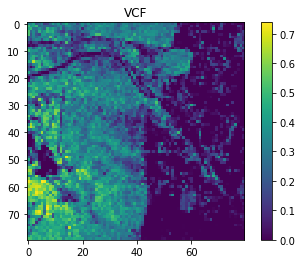

In [122]:
plt.imshow(np.rot90(vcf_raster))
plt.colorbar()
plt.title("VCF")

Text(0.5, 1.0, 'lcf_h')

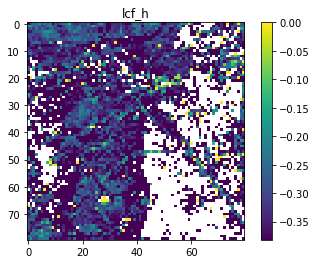

In [123]:
plt.imshow(np.rot90(lcf_h))
plt.colorbar()
plt.title("lcf_h")

Text(0.5, 1.0, 'lcf_os')

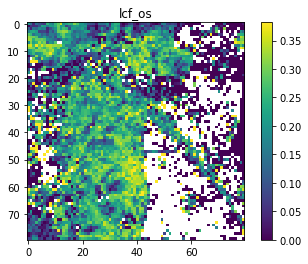

In [124]:
plt.imshow(np.rot90(lcf_os))
plt.colorbar()
plt.title("lcf_os")

Text(0.5, 1.0, 'lcf_us')

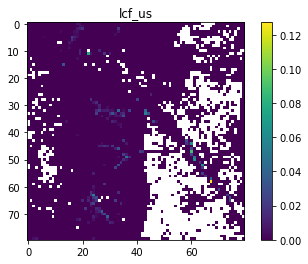

In [125]:
plt.imshow(np.rot90(lcf_us))
plt.colorbar()
plt.title("lcf_us")